Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1.m\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import curve_fit
from scipy.io import loadmat
from fnc_fit_and_score import fnc_fit_and_score
from multiprocessing import Pool

In [55]:
def sliding_window(elements, window_size):
  if len(elements) <= window_size:
    return elements

  windows = []
  for i in range(len(elements) - window_size + 1):
    windows.append(elements[i:i + window_size])

  return windows

In [56]:
# MODIFY HERE
# what conditions were the RNNs trained on?
RNN_params = {
    'prob_split': '70_30',
    'afc': [6, 2],
    'coh': ['hi', 'lo'],
    'feedback': False,
    'thresh': [.3, .7],
    'model': 1
}

D_params = {
    'time_avg': False,
    't_win': [130, -1],
    'n_cvs': 5,
    'num_cgs': 30,
    'label': ['stim', 'choice'],  # 'stim' or 'choice'
    'units': 'all',  # 'all' or 'exc' or 'inh'
    'pred': 'all'  # 'expected' or 'unexpected', 'all'
}
# Timing of task
task_info = {
    'trials': 1000,
    'trial_dur': 250,
    'stim_on': 80,
    'stim_dur': 50
}
n_cvs = 5
window = 50
# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )

modelnum = RNN_params['model']

In [57]:
combinations = list(itertools.product(RNN_params['afc'], RNN_params['coh'], D_params['label']))

for afc, coh, label in combinations:
    # Load data
    if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{afc}afc/feedforward_only/{coh}_coh"
    else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{afc}afc/feedforward_only/{coh}_coh"
    
    # Chose the model
    mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
    model_path = os.path.join(data_dir, mat_files[RNN_params['model']]) 
    model = loadmat(model_path) # model.keys()
    
    # get the data from layer 1 decode stim
    # this is a [trial x time step x unit] matrix
    data_file = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_balanced.npz"
    data = np.load(data_file)
    data_d = data['fr1']
    if label == 'stim':
        labs = data['labs'].squeeze()
    elif label == 'choice':
        labs = data['outs'][:,-1]
    
    # get some info about structure of the data
    tris = data_d.shape[0]             # number of trials
    tri_ind = np.arange(0,tris)      # list from 0...tris
    hold_out = int( tris / n_cvs )   # how many trials to hold out
    thresh = RNN_params.get('thresh', [.3, .7])
    if label == 'stim':
        n_classes = len(np.unique(labs))
    else:
        n_classes = 2
    if D_params['time_avg'] :
        data_d = np.mean( data_d[ :,D_params['t_win'][0]:D_params['t_win'][1],: ], axis = 1 ) # average over time window
        acc = np.zeros(n_cvs)
        cm = np.zeros((n_cvs, n_classes, n_classes))
        class_acc = np.zeros((n_cvs, n_classes))
        # Within each cross-validation fold
        for i in range(n_cvs):
    
            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]
    
            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )
    
            # get the training data (X) and the training labels (y)
            X = data_d[ trn_ind,: ]
            if label == 'stim':
                y = labs[trn_ind]
            else:
                y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)
    
    
            # Fit the model on the binary labels
            grid.fit( X, y )
    
            # get the test data (X) and the test labels (y)
            X_test = data_d[tst_ind, :]
            if label == 'stim':
                y_test = labs[tst_ind]
            else:
                y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)
    
    
            # predict!
            y_pred = grid.predict(X_test)
            score = grid.score( X_test,y_test )
            acc[i] += score  # Append accuracy for this CV fold
            # confusion matrix
            cm[i] += confusion_matrix(y_test, y_pred)
    
            # Evaluate accuracy
            accuracy = np.mean( acc )
            for cls in range(n_classes):
                cls_ind = y_test == cls
                class_acc[i, cls] += (np.sum(y_pred[cls_ind] == cls) / np.sum(cls_ind))
                
            
            # Print overall results
            #print(f'CV: {i}, {grid.best_estimator_}')
        print(f'done decoding')
        cm_mean = np.mean(cm, axis = 0)
        exec(f'{coh}_{afc}_{label}_all{model}_avg = cm_mean')
    else:
    # Do decoding - parallel 
        times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
        pool = Pool(processes=round(os.cpu_count() * .8))
        with pool:  # use 70% of cpus
            results = pool.starmap(fnc_fit_and_score, [
                (t, np.mean( data_d[:,t, :], axis = 1 ), tri_ind, hold_out, n_cvs, n_classes, labs, label, thresh, grid)
                for t in times
            ], chunksize = 10)
        pool.close()
        # Process the results from each worker process (list of lists of accuracies)
        #decoding_acc = np.mean(np.array(results), axis=1)
        print(f'done decoding')
        acc = np.array(results)    
        exec(f'{coh}_{afc}_{label}_all{modelnum} = acc')
print(f'done saving')

done decoding
done decoding
done decoding
done decoding
done decoding
done decoding
done decoding
done decoding
done saving


In [58]:
    
full_file = f'/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_balanced_all{modelnum}.npz'
np.savez(full_file, lo_2_stim_all1 = lo_2_stim_all1, lo_6_stim_all1 = lo_6_stim_all1, hi_2_stim_all1 = hi_2_stim_all1, hi_6_stim_all1 = hi_6_stim_all1, lo_2_choice_all1 = lo_2_choice_all1, lo_6_choice_all1 = lo_6_choice_all1, hi_2_choice_all1 = hi_2_choice_all1, hi_6_choice_all1 = hi_6_choice_all1)
print(f'done saving')

done saving


In [38]:
# load and graph
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_stim_balanced_all1.npz'
accs1 = np.load(full_file)

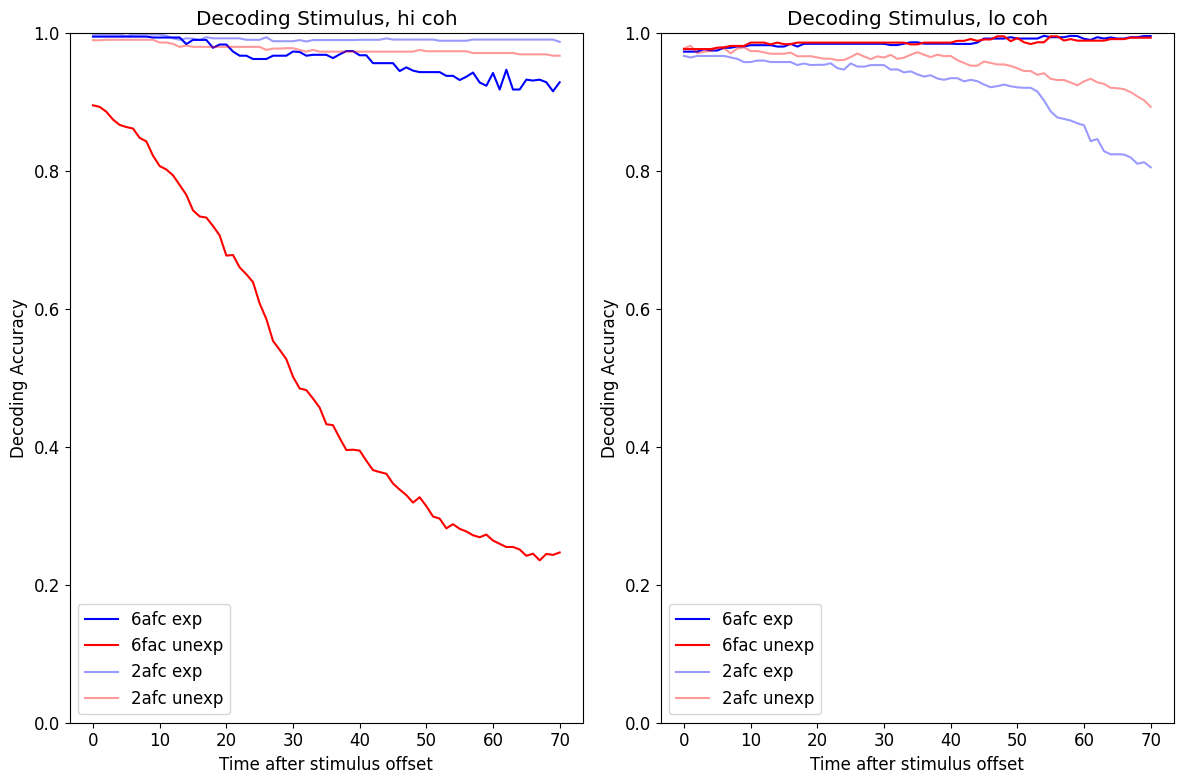

In [53]:
# plots
fig, axs = plt.subplots(1,2, figsize=(12, 8))

# Plot 1
axs[0].plot(accs1['hi_6_stim_all1'][:,0], color='blue', label='6afc exp')
axs[0].plot(np.mean(accs1['hi_6_stim_all1'][:,1:5], axis = 1), color='red',  label='6fac unexp')
axs[0].plot(accs1['hi_2_stim_all1'][:,0], color='blue',alpha=0.4, label='2afc exp')
axs[0].plot(np.mean(accs1['hi_2_stim_all1'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[0].set_xlabel('Time after stimulus offset')
axs[0].set_ylabel('Decoding Accuracy')
axs[0].set_title('Decoding Stimulus, hi coh')
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot 2
axs[1].plot(accs1['lo_6_stim_all1'][:,0], color='blue', label='6afc exp')
axs[1].plot(np.mean(accs1['lo_6_stim_all1'][:,1:5], axis = 1), color='red',  label='6fac unexp')
axs[1].plot(accs1['lo_2_stim_all1'][:,0], color='blue',alpha = 0.4, label='2afc exp')
axs[1].plot(np.mean(accs1['lo_2_stim_all1'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[1].set_xlabel('Time after stimulus offset')
axs[1].set_ylabel('Decoding Accuracy')
axs[1].set_title('Decoding Stimulus, lo coh')
axs[1].set_ylim(0, 1)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

plt.savefig(f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/stim_all1_plots_06032024.png")

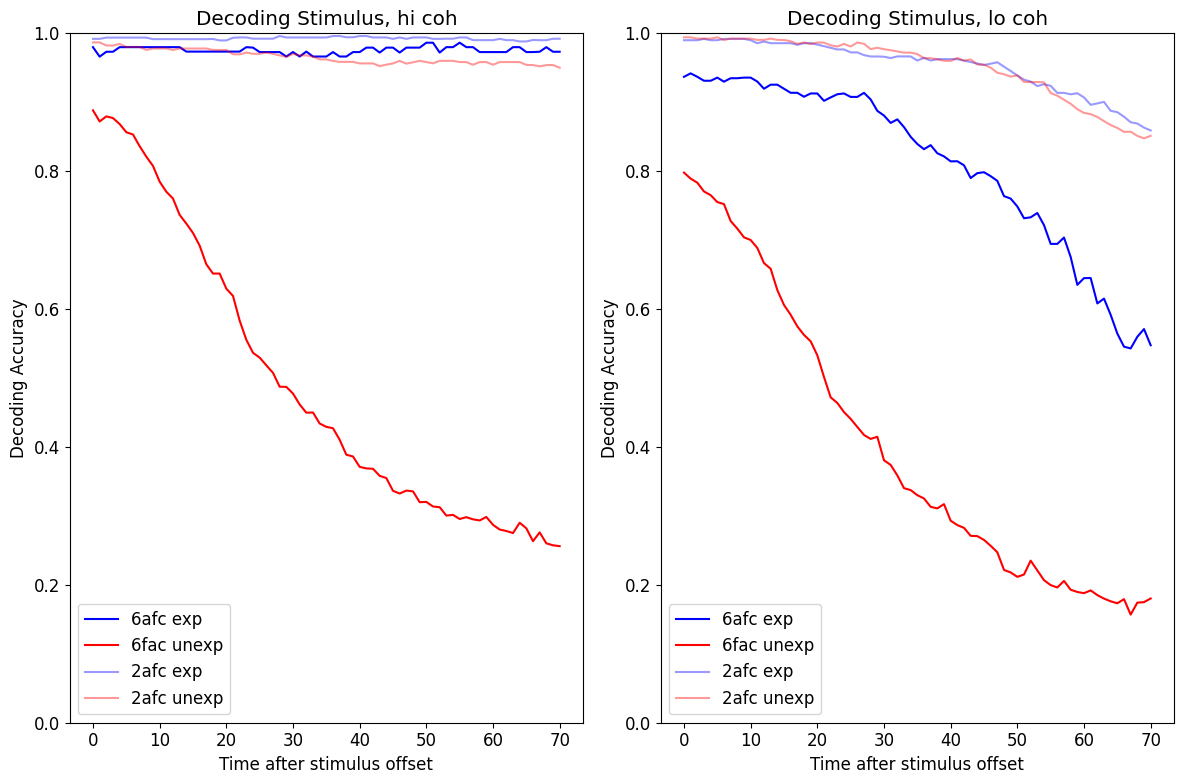

In [52]:
full_file = '/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_stim_balanced_all0.npz'
accs0 = np.load(full_file)
# plots
fig, axs = plt.subplots(1,2, figsize=(12, 8))

# Plot 1
axs[0].plot(accs0['hi_6_stim_all0'][:,0], color='blue', label='6afc exp')
axs[0].plot(np.mean(accs0['hi_6_stim_all0'][:,1:5], axis = 1), color='red', label='6fac unexp')
axs[0].plot(accs0['hi_2_stim_all0'][:,0], color='blue',alpha = 0.4, label='2afc exp')
axs[0].plot(np.mean(accs0['hi_2_stim_all0'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[0].set_xlabel('Time after stimulus offset')
axs[0].set_ylabel('Decoding Accuracy')
axs[0].set_title('Decoding Stimulus, hi coh')
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot 2
axs[1].plot(accs0['lo_6_stim_all0'][:,0], color='blue', label='6afc exp')
axs[1].plot(np.mean(accs0['lo_6_stim_all0'][:,1:5], axis = 1), color='red', label='6fac unexp')
axs[1].plot(accs0['lo_2_stim_all0'][:,0], color='blue', alpha = 0.4,label='2afc exp')
axs[1].plot(np.mean(accs0['lo_2_stim_all0'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[1].set_xlabel('Time after stimulus offset')
axs[1].set_ylabel('Decoding Accuracy')
axs[1].set_title('Decoding Stimulus, lo coh')
axs[1].set_ylim(0, 1)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

plt.savefig(f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/stim_all0_plots_06032024.png")

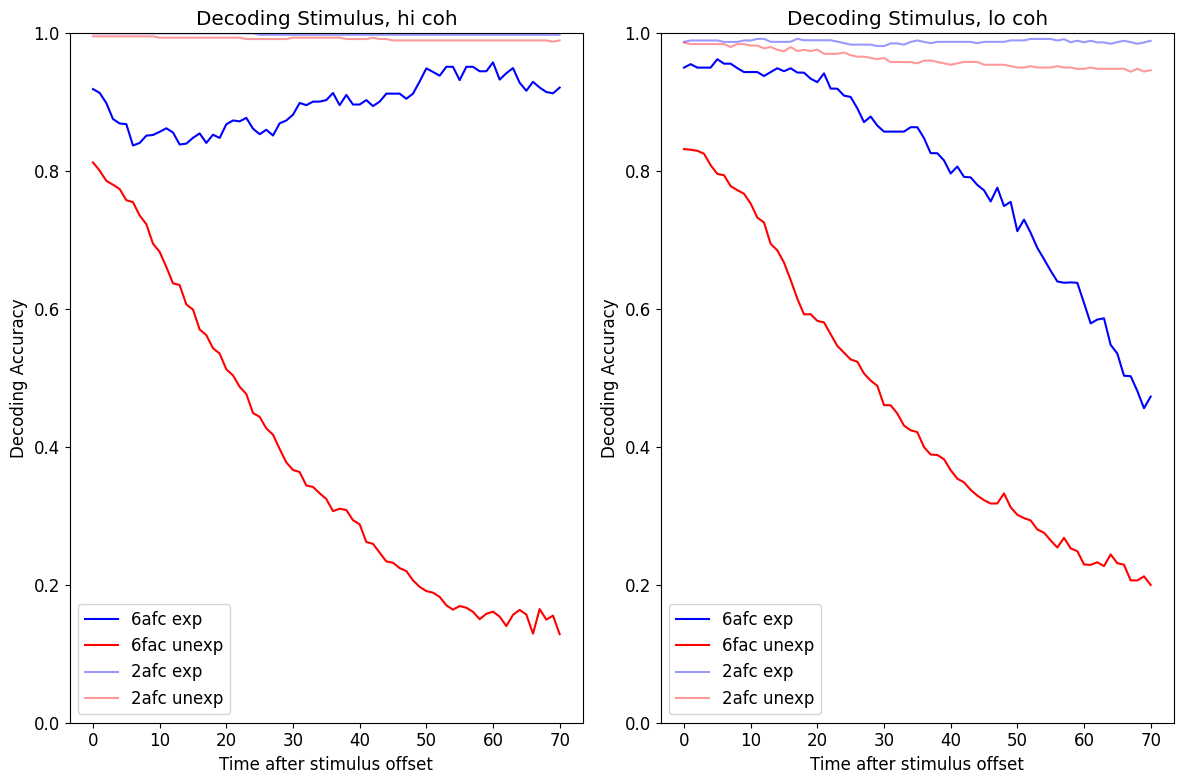

In [51]:
full_file = f'/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/results_balanced_all{modelnum}.npz'
accs2 = np.load(full_file)
# plots
fig, axs = plt.subplots(1,2, figsize=(12, 8))

# Plot 1
axs[0].plot(accs2['hi_6_stim_all2'][:,0], color='blue', label='6afc exp')
axs[0].plot(np.mean(accs2['hi_6_stim_all2'][:,1:5], axis = 1), color='red', label='6fac unexp')
axs[0].plot(accs2['hi_2_stim_all2'][:,0], color='blue', label='2afc exp', alpha = 0.4)
axs[0].plot(np.mean(accs2['hi_2_stim_all2'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[0].set_xlabel('Time after stimulus offset')
axs[0].set_ylabel('Decoding Accuracy')
axs[0].set_title('Decoding Stimulus, hi coh')
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot 2
axs[1].plot(accs2['lo_6_stim_all2'][:,0], color='blue', label='6afc exp')
axs[1].plot(np.mean(accs2['lo_6_stim_all2'][:,1:5], axis = 1), color='red', label='6fac unexp')
axs[1].plot(accs2['lo_2_stim_all2'][:,0], color='blue', label='2afc exp', alpha = 0.4)
axs[1].plot(np.mean(accs2['lo_2_stim_all2'][:,1:2], axis = 1), color='red', alpha=0.4, label='2afc unexp')
axs[1].set_xlabel('Time after stimulus offset')
axs[1].set_ylabel('Decoding Accuracy')
axs[1].set_title('Decoding Stimulus, lo coh')
axs[1].set_ylim(0, 1)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

plt.savefig(f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/decoding/stim_all2_plots_06032024.png")

In [42]:
# plot all three models

